In [1]:
!wget https://github.com/unburied/DS-Unit-2-Applied-Modeling/raw/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-08-11 20:05:23--  https://github.com/unburied/DS-Unit-2-Applied-Modeling/raw/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/unburied/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip [following]
--2019-08-11 20:05:24--  https://raw.githubusercontent.com/unburied/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip.3’

caterpillar-tube-pr 100%[===================>] 804.48K  --.-KB/s    in 0.1s    

201

In [2]:
#!unzip -n caterpillar-tube-pricing.zip 

In [3]:
#!unzip data.zip

In [4]:
from glob import glob
import pandas as pd

#load data into df dictionary and clean names as keys
df_dict = {}
for file in glob('competition_data/*'):
    name = file.replace('competition_data/', '').replace('.csv', '')
    df_dict[name] = pd.read_csv(file) 

In [5]:
df_dict.keys()

dict_keys(['type_end_form', 'comp_elbow', 'bill_of_materials', 'type_connection', 'comp_float', 'components', 'tube_end_form', 'tube', 'test_set', 'comp_other', 'comp_boss', 'comp_adaptor', 'specs', 'type_component', 'train_set', 'comp_nut', 'comp_threaded', 'comp_straight', 'comp_tee', 'comp_sleeve', 'comp_hfl'])

In [6]:
#extract data to split and begin exploration
trainval = df_dict['train_set']
test = df_dict['test_set']

In [7]:
trainval.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [8]:
#get unique id's for assemblies to split
train_tubes = trainval.tube_assembly_id.unique()
test_tubes = test.tube_assembly_id.unique()

set(train_tubes) & set(test_tubes)

set()

In [9]:
from sklearn.model_selection import train_test_split

#split for train and validation
train_assemblies, val_assemblies = train_test_split(train_tubes,
                                                   random_state = 42)
#confirm both sets have unique assemblies
set(train_assemblies) & set(val_assemblies)

set()

In [10]:
#split trainval in train and val subsets
train = trainval[trainval.tube_assembly_id.isin(train_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_assemblies)]

assert len(train) + len(val) == len(trainval)

In [11]:
#get baseline == mean
import numpy as np

target = 'cost'

#set target and predictions
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value = y_train.mean())

In [12]:
#score baseline
from sklearn.metrics import mean_squared_log_error

def rmsle(pred, true):
    score = np.sqrt(mean_squared_log_error(pred, true))
    statement = f'Score = {score}'
    return print(statement)

In [13]:
rmsle(y_pred, y_val)

Score = 0.9418101276064408


In [14]:
#use simple model to build upon baseline
from sklearn.ensemble import RandomForestRegressor

#use numerical feature quantity for model baseline
feature = ['quantity']
X_train = train[feature]
X_val = val[feature]

#fit model
model = RandomForestRegressor(n_estimators = 350, max_depth = 20)
model.fit(X_train, y_train)

#get score
y_pred = model.predict(X_val)
rmsle(y_pred, y_val)

Score = 0.6907132369903266


In [82]:
#wrangle data
def wrangle(df):
    X = df.copy()
    
    #merge related columns for separate files
    X = mash(X)
    
    #add bills data
    X = X.merge(clean_bills(df_dict['bill_of_materials']), how = 'left')
    
    X['quote_date'] = pd.to_datetime(X.quote_date, infer_datetime_format = True)
    X['year'] = X.quote_date.dt.year
    X['month'] = X.quote_date.dt.month
    X['day'] = X.quote_date.dt.day
    X['day_of_year'] = X.quote_date.dt.dayofyear
    X['day_of_week'] = X.quote_date.dt.dayofweek
    X = X.drop(columns = 'quote_date')
    
    X = X.drop(columns = 'tube_assembly_id')
    
    
    return X

In [16]:
#function to merge all data
def mash(X):
    X = X.copy()
    for k,v in df_dict.items():
        #determine if columns share values
        shared_columns = set(X.columns) & set(v.columns)
        #if so merge
        if shared_columns:
            X = X.merge(v, how = 'left')
    #drop columns that contain NA for now
    X = X.dropna(axis = 1)        
    return X

In [17]:
#wrangle data and pop targets
y_train = train.pop('cost')
y_val = val.pop('cost')
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [18]:
#drop these columns to match train dimensions
test_wrangled = test_wrangled.drop(columns = ['quote_date', 'id'])

In [19]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

#make pipeline to encode and model data
pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestRegressor(n_estimators = 150,
                                             max_depth = 20,
                                             n_jobs = -1))
#fit data and get score
pipeline.fit(train_wrangled, y_train)
y_pred = pipeline.predict(val_wrangled)
rmsle(y_pred, y_val)

Score = 0.34634745590895855


In [109]:
def submission(test, attempt):   
    attempt = 'submission-' + str(attempt) + '.csv'
    sample_submission = pd.read_csv('sample_submission.csv')
    submission = sample_submission.copy()
    submission['cost'] = np.expm1(pipeline.predict(test))
    submission.to_csv(attempt, index=False)

In [21]:
#explore dictionary for relations
for k,v in df_dict.items():
    if 'comp' in k and len(v.columns) < 10:
        print(k)

comp_float
components
comp_other
type_component
comp_hfl


In [22]:
id_info = df_dict['bill_of_materials']

In [23]:
id_info.head().transpose()

,0,1,2,3,4
tube_assembly_id,TA-00001,TA-00002,TA-00003,TA-00004,TA-00005
component_id_1,C-1622,C-1312,C-1312,C-1312,C-1624
quantity_1,2,2,2,2,1
component_id_2,C-1629,NaN,NaN,NaN,C-1631
quantity_2,2,NaN,NaN,NaN,1
component_id_3,NaN,NaN,NaN,NaN,C-1641
quantity_3,NaN,NaN,NaN,NaN,1
component_id_4,NaN,NaN,NaN,NaN,NaN
quantity_4,NaN,NaN,NaN,NaN,NaN
component_id_5,NaN,NaN,NaN,NaN,NaN


In [24]:
any(trainval.tube_assembly_id.isin(id_info.tube_assembly_id))

True

In [74]:
def clean_bills(df):
    id_info = df.copy()
    
    #initialize a columns of zeros to count up from
    id_info['num_of_comps'] = [0 for _ in range(id_info.shape[0])]
    id_info['total_quantity'] = [0 for _ in range(id_info.shape[0])]
    
    #increment new columns for any column not containing a null value
    for col in range(1,9):
        id_info['num_of_comps'] = np.where(id_info[f'component_id_{col}'].isnull(),
                                           id_info.num_of_comps , id_info.num_of_comps + 1)
        id_info['total_quantity'] = np.where(id_info[f'quantity_{col}'].isnull(),
                                           id_info.total_quantity , 
                                           id_info.total_quantity + id_info[f'quantity_{col}'])
        
    #return df filtered with new columns and 3 components ids
    filters = ['component_id_1','component_id_2','component_id_3',
               'num_of_comps', 'total_quantity', 'tube_assembly_id']
    
    return id_info[filters]

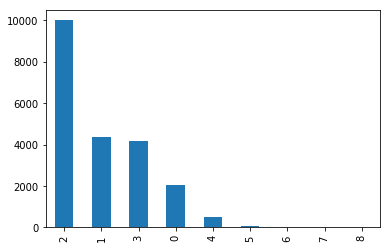

In [67]:
%matplotlib inline 
import matplotlib.pyplot as plt 

id_info.num_of_comps.value_counts().plot.bar()

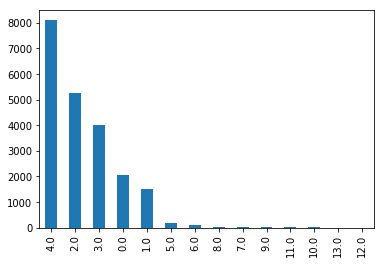

In [64]:

id_info.total_quantity.value_counts().plot.bar()

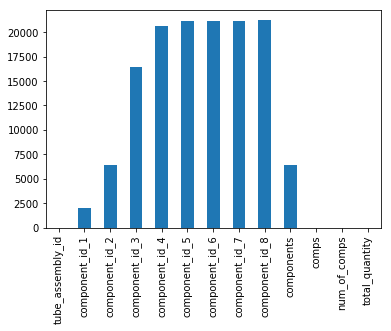

In [69]:
drop_quants = [f'quantity_{x}' for x in range(1,9)]
id_info.drop(columns = drop_quants).isnull().sum().plot.bar()

In [101]:
test_wrangled.head()

,id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,comps,num_of_comps,total_quantity,diameter,...,num_bracket,other,component_id_1,component_id_2,component_id_3,year,month,day,day_of_year,day_of_week
0,1,S-0066,0,0,Yes,1,0,2,4.0,12.7,...,0,0,C-1622,C-1629,NaN,2013,6,23,174,6
1,2,S-0066,0,0,Yes,2,0,2,4.0,12.7,...,0,0,C-1622,C-1629,NaN,2013,6,23,174,6
2,3,S-0066,0,0,Yes,5,0,2,4.0,12.7,...,0,0,C-1622,C-1629,NaN,2013,6,23,174,6
3,4,S-0066,0,0,Yes,10,0,2,4.0,12.7,...,0,0,C-1622,C-1629,NaN,2013,6,23,174,6
4,5,S-0066,0,0,Yes,25,0,2,4.0,12.7,...,0,0,C-1622,C-1629,NaN,2013,6,23,174,6


In [103]:
#wrangle data
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

#costs end up being reintroduced, so dropping
train_wrangled = train_wrangled.drop(columns = 'cost')
val_wrangled = val_wrangled.drop(columns = 'cost')

#test still has id somehow
test_wrangled = test_wrangled.drop(columns = 'id')
test_wrangled.shape, val_wrangled.shape, train_wrangled.shape

((30235, 30), (7585, 30), (22628, 30))

In [105]:
#convert to log values
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [106]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_job=-1))
    
pipeline.fit(train_wrangled, y_train_log)
y_pred_log = pipeline.predict(val_wrangled)

/home/unburied/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:02:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [107]:
#score baseline
from sklearn.metrics import mean_squared_error

def rmse(pred, true):
    score = np.sqrt(mean_squared_error(pred, true))
    statement = f'Score = {score}'
    return print(statement)

In [108]:
rmse(y_pred_log, y_val_log)

Score = 0.2785095758557081


In [110]:
submission(test_wrangled, 3)